# Exploratory Data Analysis

In [1]:
#import 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import string
import re
import nltk
from wordcloud import WordCloud,STOPWORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from keras import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import collections
def RMSE(Y,YHAT):
    return np.sqrt(mean_squared_error(Y,YHAT))

stopwords=list(STOPWORDS)

plt.rc('figure',figsize=(20,11))

def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [2]:
a_data = pd.read_csv('AB_US_2020.csv',usecols=['id','name','latitude','longitude','room_type','price','minimum_nights','number_of_reviews','last_review','reviews_per_month','calculated_host_listings_count',
                                                                                'availability_365','city'])
a_data.head(3)

,id,name,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville


In [3]:
numeric_features = a_data.select_dtypes(include=['int64','float64']).columns
nominal_features = a_data.select_dtypes(include=['object'])
numeric_features=numeric_features.delete(0)

In [4]:
a_data = a_data.dropna()

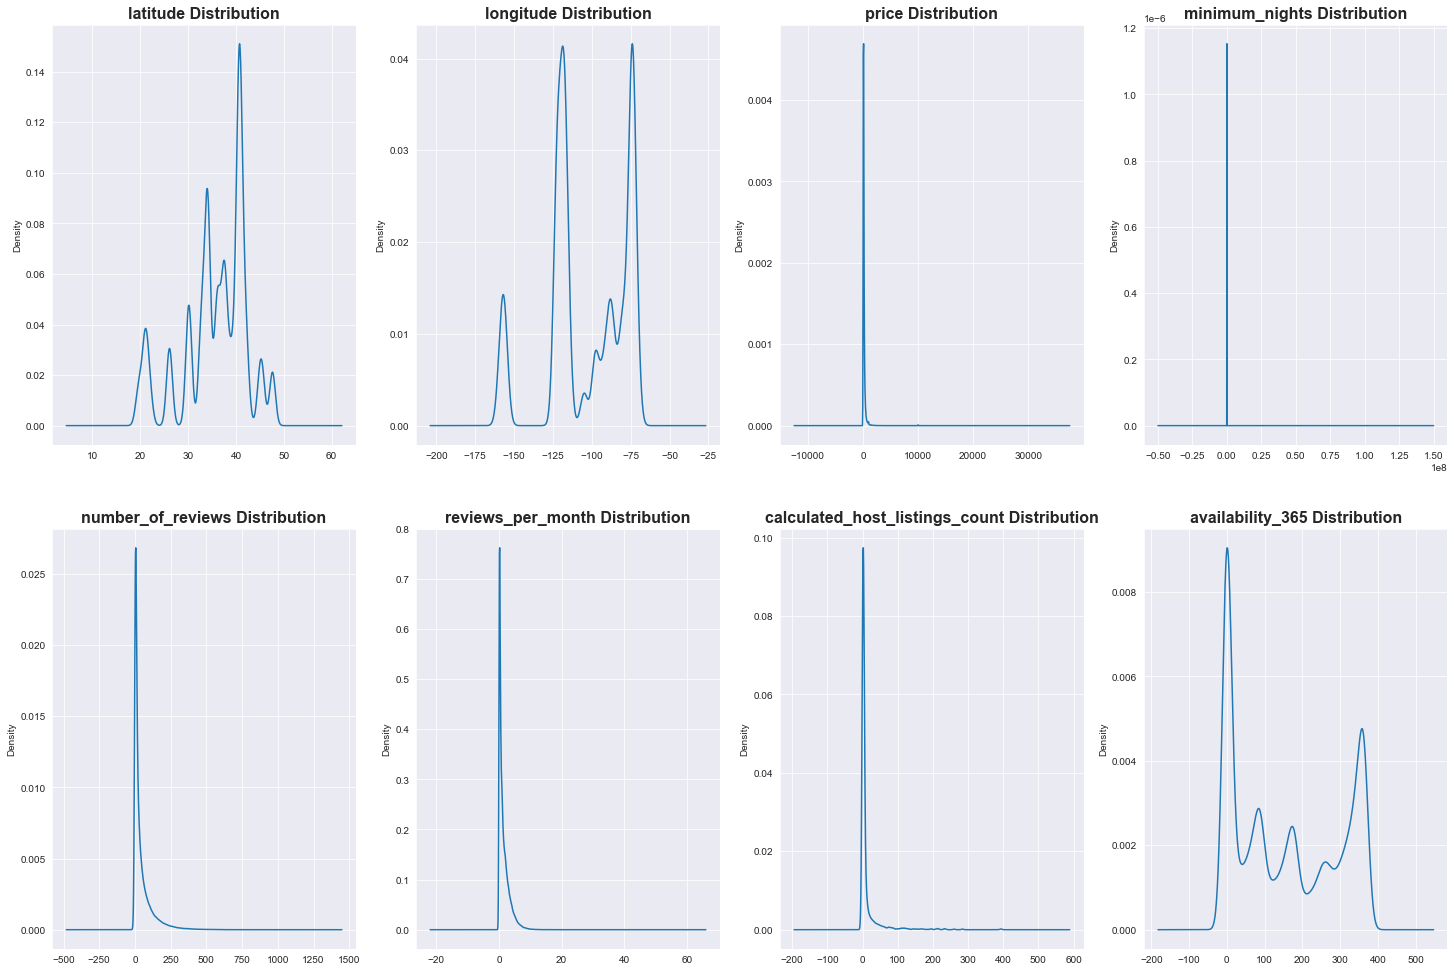

In [5]:
# Numeric Features Distribution Analysis
fig, axes = plt.subplots(nrows=2, ncols=4)
aux = 0
fig.set_figheight(17)
fig.set_figwidth(25)
for row in axes:
    for col in row:
        a_data[numeric_features[aux]].plot(kind='kde',ax=col)
        col.set_title(numeric_features[aux] +' Distribution',fontsize=16,fontweight='bold')
        aux+=1

In [6]:
# Outlier Removal
# Removing Outliers
lower_bound = .25
upper_bound = .75
iqr = a_data[a_data['price'].between(a_data['price'].quantile(lower_bound), a_data['price'].quantile(upper_bound), inclusive=True)]
iqr = iqr[iqr['number_of_reviews'] > 0]
iqr = iqr[iqr['calculated_host_listings_count'] < 10]
iqr = iqr[iqr['number_of_reviews'] < 200]
iqr = iqr[iqr['minimum_nights'] < 10]
iqr = iqr[iqr['reviews_per_month'] < 5]

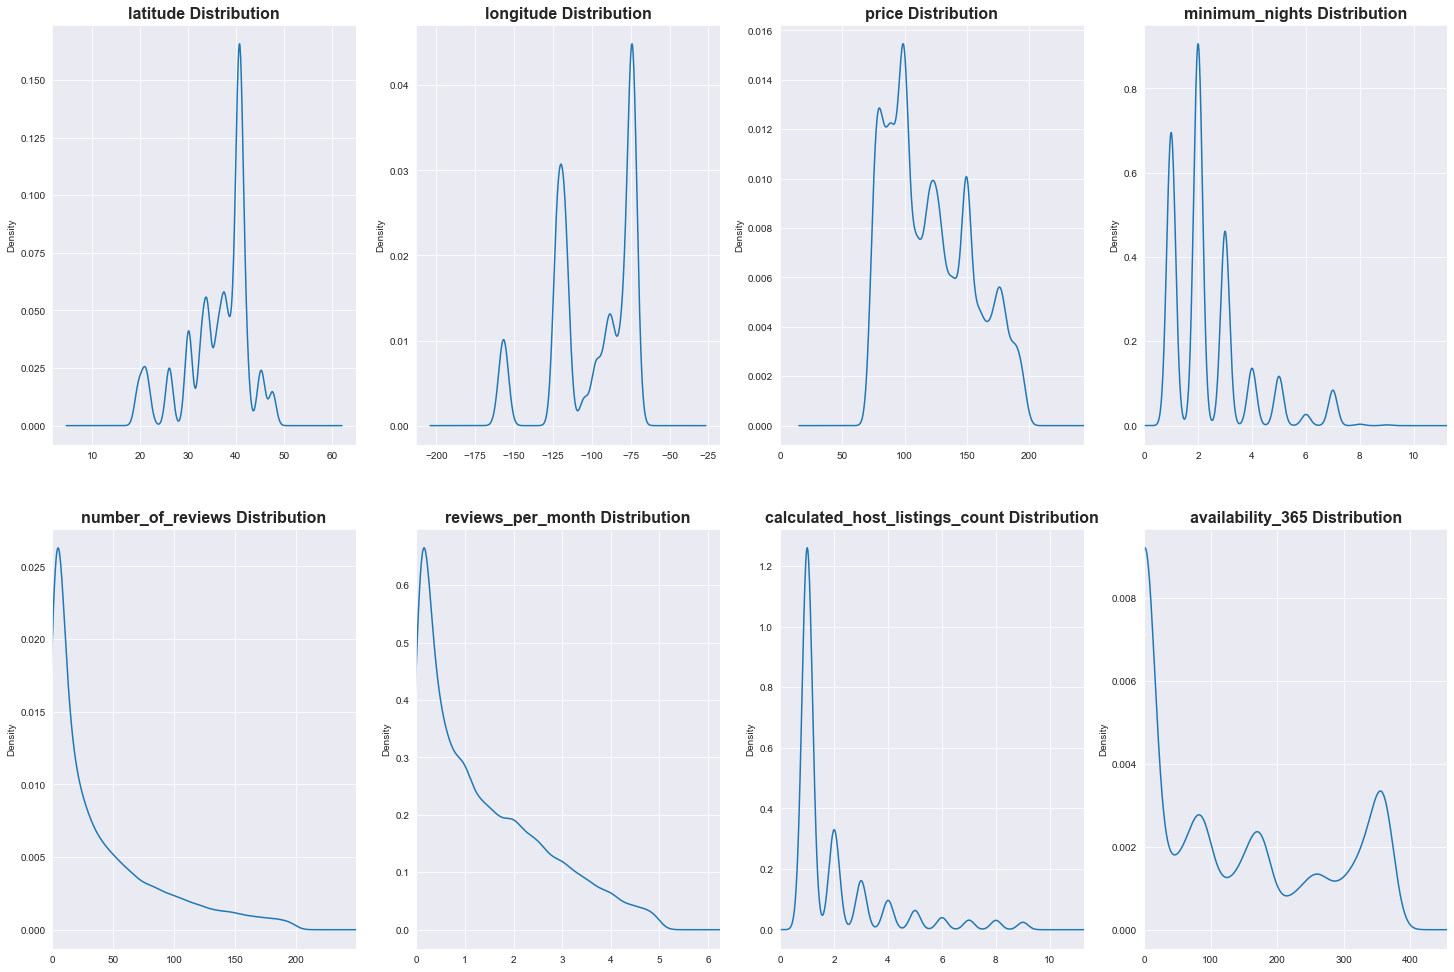

In [7]:
# Processed Distributions After Ourlier Removal
fig, axes = plt.subplots(nrows=2, ncols=4)
aux = 0
fig.set_figheight(17)
fig.set_figwidth(25)
for row in axes:
    for col in row:
        iqr[numeric_features[aux]].plot(kind='kde',ax=col)
        if numeric_features[aux] not in ['latitude','longitude']:
            col.set_xlim(0,iqr[numeric_features[aux]].max()+iqr[numeric_features[aux]].max()*0.25)
        col.set_title(numeric_features[aux] +' Distribution',fontsize=16,fontweight='bold')
        aux+=1

So we see that after we removed most of the outliers in our data we are left we more meaningful distributions from which we can extract some insight. We can see that the number_of_reveiws feature, as well as the reveiws_pre_month feature, follow an exponential distribution in contrast to all other numeric features in the dataset which seem to follow a multimodal distribution which makes sense because there are many underlying groups in our dataset (different location for example)

In [8]:
pr_data =iqr.copy()
desc = pr_data.describe()
desc.loc['skew'] = desc.skew()
desc.loc['skew'] = desc.kurt()
pd.set_option('display.float_format', lambda x: '%.5f' % x)
desc

,id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,54240.00000,54240.00000,54240.00000,54240.00000,54240.00000,54240.00000,54240.00000,54240.00000,54240.00000
mean,23532126.65017,36.30716,-99.26707,120.66729,2.39054,39.81374,1.37897,1.98003,134.10437
std,12487520.31611,6.66777,25.66866,33.37854,1.45147,45.53361,1.24405,1.73188,133.81626
min,344.00000,18.98232,-159.71143,75.00000,1.00000,1.00000,0.01000,1.00000,0.00000
25%,13878154.00000,32.79478,-118.39360,92.00000,1.00000,5.00000,0.30000,1.00000,0.00000
50%,23433545.50000,37.80744,-90.08964,115.00000,2.00000,21.00000,1.00000,1.00000,89.00000
75%,34419871.50000,40.73287,-73.98891,149.00000,3.00000,59.00000,2.19000,2.00000,259.00000
max,45492496.00000,47.73462,-70.99595,195.00000,9.00000,199.00000,4.99000,9.00000,365.00000
skew,-0.65301,8.99998,8.99974,8.99974,9.00000,8.99971,9.00000,9.00000,8.99878


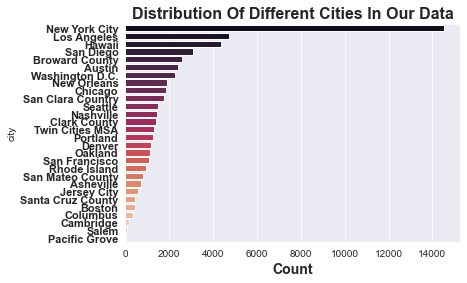

In [9]:
# City And State Based Analysis
ax = sns.countplot(y=pr_data['city'],order=pr_data['city'].value_counts().index,palette='rocket')
ax.set_yticklabels(ax.get_yticklabels(),fontsize=11,fontweight='bold')
ax.set_title('Distribution Of Different Cities In Our Data',fontsize=16,fontweight='bold')
ax.set_xlabel('Count',fontsize=14,fontweight='bold')
#ax.set_title()
plt.show()


In [10]:
states_dic = {'Asheville':'NC','Austin':'TX','Boston':'MA','Broward County':'FL','Cambridge':'MA','Chicago':'IL','Clark County':'NV','Columbus':'OH','Denver':'CO','Hawaii':'HI','Jersey City':'NJ',
             'Los Angeles':'SC','Nashville':'TN','New Orleans':'MS','New York City':'NY','Oakland':'CA','Pacific Grove':'CA','Portland':'OR','Rhode Island':'RI','Salem':'MA','San Clara Country':'CA',
             'Santa Cruz County':'CA','San Diego':'CA','San Francisco':'CA','San Mateo County':'CA','Seattle':'WA','Twin Cities MSA':'MN','Washington D.C.':'DC'}

pr_data['state'] = pr_data['city'].apply(lambda x : states_dic[x])

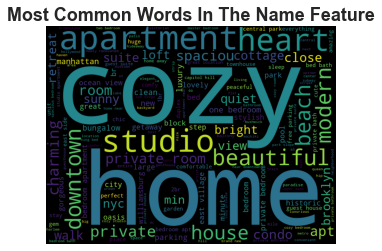

In [11]:
# Text based analysis
names = ' '.join(pr_data['name'].str.lower().values)
plt.imshow(WordCloud(width=800,height=600,min_font_size=10,stopwords=stopwords).generate(names))
plt.title('Most Common Words In The Name Feature',fontsize=18,fontweight='bold')
plt.axis('off')


names = re.sub("^\d+\s|\s\d+\s|\s\d+$", "", names)
names = re.findall(r'\w+', names)
names = ' '.join([tok for tok in names if tok not in stopwords and len(tok) >2])

names_freq_dic = nltk.FreqDist(names.split(' '))
dict(names_freq_dic)

plt.show()

From the word cloud above we can confirm our assumption that there are words in the name of the listing which describe the product itself, words which can point to elements and attributes which donate to the price formulation. The sequential neural network model we will construct will try to predict the price of a listing solely on these words.

# Model Selection And Evaluation

In [14]:
# Vocabulary Extraction And Preprocessing
vocab = collections.Counter(' '.join(pr_data['name']).split(' '))

MAX_LENGTH = max(pr_data['name'].apply(lambda x: len(x)))
VOCAB_SIZE = len(vocab.keys())
VECTOR_SPACE = 100

encoded_docs = [tf.keras.preprocessing.text.one_hot(d,VOCAB_SIZE) for d in pr_data.name]

padded_docs = tf.keras.preprocessing.sequence.pad_sequences(encoded_docs,maxlen=MAX_LENGTH,padding='post')

padded_docs_eval = padded_docs[0:1000]
padded_docs = padded_docs[1000:]
Y = pr_data.price[1000:]
Y_eval = pr_data.price[:1000]

We have created constant variables for our Embedding layer which represent the vocabulary size of the 'name' feature, the target vector space we want to map our word embeddings to, and the length of the input. We also preprocessed all our words by converting them into a one-hot sparse matrix and padding each vector to the same length.

In [19]:
# Sequantial Model Assembling
FCNN_MODEL = Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE,VECTOR_SPACE,input_length=MAX_LENGTH),
    tf.keras.layers.Flatten(),
    Dense(activation='relu',units=5),
    Dense(activation='relu',units=1)
    
])

FCNN_MODEL.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [20]:
tf.keras.utils.plot_model(FCNN_MODEL,show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [17]:
!pip install pydot

In [18]:
!pip install graphviz

In [21]:
# Model Training
history = FCNN_MODEL.fit(padded_docs, Y,validation_data=(padded_docs_eval,Y_eval),epochs=2,batch_size=150)

Epoch 1/2
355/355 [==============================] - 13s 38ms/step - loss: 2516.7849 - mae: 38.2955 - val_loss: 1103.3083 - val_mae: 28.2949
Epoch 2/2
355/355 [==============================] - 14s 40ms/step - loss: 1027.1266 - mae: 27.1627 - val_loss: 1051.4996 - val_mae: 27.2200


In [22]:
predictions = FCNN_MODEL.predict(padded_docs)
predictions = predictions.reshape(-1)

In [23]:
# Model Evaluation
print('ROOT MEAN SQUARED ERROR: %f' % (RMSE(predictions,Y)))

ROOT MEAN SQUARED ERROR: 31.298782


In [24]:
pd.DataFrame({"Actual Price":Y.values,'Prediction':predictions}).head(10)

,Actual Price,Prediction
0,131,122.56657
1,126,129.25522
2,92,112.87859
3,150,122.16912
4,80,109.35683
5,125,109.06321
6,141,120.07381
7,150,115.09963
8,90,113.87535
9,80,114.25574


## Creating New DataFrame For Ensembled Learning
Using the predicted price from our sequential embeddings model we will combine the results with the corresponding USA state of each listing (encoded into one hot features) and use this data to train a new random forest model.

In [25]:
t_df = pd.DataFrame({"Actual Price":Y.values,'Prediction':predictions})
t_df['number_of_reviews'] = pr_data.loc[Y.index,'number_of_reviews'].values
t_df = pd.concat([t_df,pd.get_dummies(pr_data.loc[Y.index,'state']).drop(columns= ['WA']).reset_index().drop(columns='index')],axis=1)
t_df = pd.concat([t_df,pd.get_dummies(pr_data.loc[Y.index,'room_type']).drop(columns=['Shared room']).reset_index().drop(columns='index')],axis=1)
t_df

,Actual Price,Prediction,number_of_reviews,CA,CO,DC,FL,HI,IL,MA,...,NY,OH,OR,RI,SC,TN,TX,Entire home/apt,Hotel room,Private room
0,131,122.56657,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,126,129.25522,143,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,92,112.87859,154,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,150,122.16912,154,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,80,109.35683,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53235,144,118.73149,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
53236,132,131.13680,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
53237,112,123.12816,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
53238,78,121.09613,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [26]:
X_cols =t_df.iloc[:,1:]

In [28]:
# Fitting Ensembled Random Forest Model
RF_pipeline = Pipeline(steps=[('model',RandomForestRegressor(random_state=42))])

RF_pipeline.fit(X_cols,t_df.iloc[:,0])

RF_predictions = RF_pipeline.predict(X_cols)

In [29]:
print('ROOT MEAN SQUARED ERROR: %f' % (RMSE(RF_predictions,Y)))

ROOT MEAN SQUARED ERROR: 12.125717


In [30]:
# Results
results = pd.DataFrame({'id':pr_data.loc[Y.index,'id'],"Actual Price":Y.values,'Prediction':RF_predictions})
results.head(10)

,id,Actual Price,Prediction
3502,5549432,131,123.42000
3512,5558324,126,118.39000
3513,5558744,92,96.72000
3514,5561157,150,135.93000
3524,5587184,80,89.44000
3533,5602667,125,113.29000
3541,5612495,141,139.97000
3545,5617149,150,142.18000
3551,5625746,90,86.95000
3555,5632201,80,84.77000


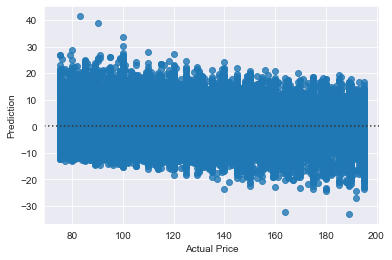

In [31]:
sns.residplot(x=results['Actual Price'],y=results['Prediction'])

Overall the residual between the actual values and the predicted values vary around between -20/20 USD which is a fairly small interval for error. we can also see our model has a small degree of heteroskedasticity in the minimum and maximum prices but the degree is low so we can assume the model did not overfit to a certain part of our data.



In [32]:
results.to_csv('Price_Predictions.csv',index=False)